# Setting up a time-varying PDE

In this example we will demonstrate the use of the package on a time-dependent
PDE, a problem of unsteady heat conduction. We will use the package to
solve for the interior diffusion of temperature from a circle held at constant
temperature.

We seek to solve the heat conduction equation with Dirichlet boundary conditions

$$\dfrac{\partial T}{\partial t} = \kappa \nabla^2 T + q + \delta(\chi) \sigma  - \kappa \nabla\cdot \left( \delta(\chi) \mathbf{n} [T] \right)$$

subject to $T = T_b$ on the immersed surface. We might be solving this external
to a surface, or it might be internal. The quantity $\sigma$ is the Lagrange
multiplier. In this context, it is the heat flux through the surface.

In the spatially discrete formulation, the problem takes the form

$$\begin{bmatrix}
\mathcal{L}_C^\kappa & R_C \\ R_C^T & 0
\end{bmatrix}\begin{pmatrix}
T \\ -\sigma
\end{pmatrix} =
\begin{pmatrix}
q - \kappa D_s [T] \\ (T^+_b + T^-_b)/2
\end{pmatrix}$$

where $\mathcal{L}_C^\kappa = \mathrm{d}/\mathrm{d}t - \kappa L_C$, where $[T] = T_b^+ - T_b^-$
is the jump in temperature across the surface. As in the time-independent problems,
we can specify whether we are solving it external or internal to a surface by setting
the boundary value to zero in the other region. However, in contrast to the
time-independent problems, we have to advance this problem in time.
The system above has the form of a *constrained ODE system*, which the `ConstrainedSystems.jl` package treats.
We will make use of this package in the example below.

To support this, there are a few additional steps in our setup of the problem:
- we (as the implementers of the PDE) need to specify the functions that calculate the
   various parts of this constrained ODE system.
- we (as the users of this implementation) need to specify the time step size,
   the initial conditions, the time integration range, and create the *integrator*
   to advance the solution.

The latter of these is very easy, as we'll find. Most of our attention will
be on the first part: how to set up the constrained ODE system. For this,
we will make use of the `ODEFunctionList`, which assembles the
various functions and operators into a `ConstrainedODEFunction`, to be used by the
`ConstrainedSystems.jl` package.

In [1]:
using ComputationalHeatTransfer
using Plots

## Set up the constrained ODE system operators
The problem type is generated with the usual macro call. In this example,
we will make use of more of the capabilities of the resulting problem
constructor for "packing" it with information about the problem.

## Solve the problem
We will solve heat conduction inside a circular region with
uniform temperature, with thermal diffusivity equal to 1.

### Set up the grid

In [2]:
Δx = 0.01
Lx = 4.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx);

### Set up the body shape.
Here, we will demonstrate the solution on a circular shape of radius 1.

In [3]:
Δs = 1.4*cellsize(g)
body = Circle(1.0,Δs);

Though the body is stationary, we still need to provide some minimal information
about its placement and (lack of) motion. We do this with the help of
the `RigidBodyMotion` structure. Technically, the placement of a body
constitutes a basic *joint* with the inertial coordinate system.
the `MotionTransform` below places the joint at the origin of the
inertial coordinate system (the first argument), with no relative rotation (the second argument).

In [4]:
X = MotionTransform([0,0],0)
joint = Joint(X)
m = RigidBodyMotion(joint,body)

1 linked system(s) of bodies
   1 bodies
   1 joints


We don't have to do anything more here because the placement of the body
is trivial. However, to demonstrate how we might do it in other problems,

In [5]:
x = zero_motion_state(body,m)
update_body!(body,x,m)

Circular body with 448 points and radius 1.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Specify the physical parameters, data, etc.
These can be changed later without having to regenerate the system.

Here, we create a dict with physical parameters to be passed in.

In [6]:
phys_params = Dict("diffusivity" => 1.0, "Fourier" => 1.0, "lineheater_flux" => 0.0, "angular velocity" => 0.0)

Dict{String, Float64} with 4 entries:
  "Fourier"          => 1.0
  "diffusivity"      => 1.0
  "lineheater_flux"  => 0.0
  "angular velocity" => 0.0

The temperature boundary functions on the exterior and interior are
defined here and assembled into a dict. Note that these functions
must have a slightly more complex signature than in time-invariant
problems: for generality, they must accept the time argument and
another argument accepting possible motions of the surfaces.

In [7]:
get_Tbplus(t,x,base_cache,phys_params,motions) = zeros_surface(base_cache)
get_Tbminus(t,x,base_cache,phys_params,motions) = ones_surface(base_cache)
bcdict = Dict("exterior" => get_Tbplus,"interior" => get_Tbminus)

Dict{String, Function} with 2 entries:
  "interior" => get_Tbminus
  "exterior" => get_Tbplus

Construct the problem, passing in the data and functions we've just
created. We pass in the body's motion (however trivial) via the
`motions` keyword.

In [8]:
prob = DirichletHeatConductionProblem(g,body,scaling=GridScaling,
                                             phys_params=phys_params,
                                             bc=bcdict,
                                             motions=m,
                                             timestep_func=timestep_fourier);

Construct the system

In [9]:
sys = construct_system(prob);

### Solving the problem
In contrast to the previous (time-independent) example, we have not
extended the `solve` function here to serve us in solving this problem.
Instead, we rely on the tools in `ConstrainedSystems.jl` to advance
the solution forward in time. This package builds from the `OrdinaryDiffEq.jl`
package, and leverages most of the tools of that package.

Set an initial condition. Here, we just get an initial (zeroed) copy of the
solution prototype that we have stored in the extra cache. We also
get the time step size for our own inspection.

In [10]:
u0 = init_sol(sys)
Δt = timestep_fourier(u0,sys)

0.0001

It is instructive to note that `u0` has two parts: a *state* and a *constraint*,
each obtained respectively with a convenience function. The state in this
case is the temperature; the constraint is the Lagrange multiplier.

In [11]:
state(u0)

Nodes{Primal, 406, 402, Float64, Matrix{Float64}} data
Printing in grid orientation (lower left is (1,1))
401×405 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0

In [12]:
constraint(u0)

448 points of scalar-valued Float64 data
448-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Now, create the integrator, with a time interval of 0 to 1. We have not
specified the algorithm here explicitly; it defaults to the `LiskaIFHERK()`
time-marching algorithm, which is a second-order algorithm for constrained
ODE systems that utilizes a matrix exponential (i.e., integrating factor)
for the linear part of the problem (the Laplacian), and a half-explicit Runge-Kutta method
for the constrained part. This method is most suitable for problems
in which there is no dependence on the Lagrange multipliers in the
constraint. (Such a problem is an index-2 differential-algebraic equation.)
Another possible choice for this problem is the first-order Euler method, `IFHEEuler()`,
which can be specified with the keyword `alg=IFHEEuler()`.

For problems that *do* have a constraint that depends on the Lagrange multipliers
such as the Neumann problem (in an upcoming example), then the default method
switches to `HETrapezoidalAB2()`, which uses a half-explicit trapezoidal method
for the constrained and linear parts, and 2nd-order Adams-Bashforth for the explicit part.

In [13]:
tspan = (0.0,1.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 406, ny = 402) cell grid of type Float64 data
  Number of Primal nodes: (nx = 405, ny = 401), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

Now advance the solution by 0.01 convective time units, by using the `step!` function,
which steps through the solution.

In [14]:
step!(integrator,0.01)

### Plot the solution
The integrator holds the most recent solution in the field `u`, which
has the same type as our initial condition `u0`. Here, we plot the state of the system at the end of the interval.

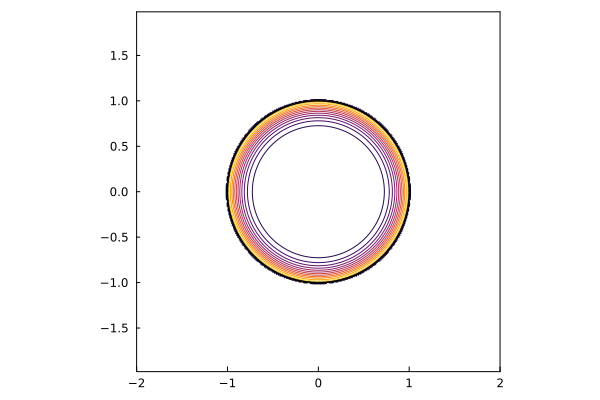

In [15]:
plot(state(integrator.u),sys)

It would be nice to just define a function called `temperature` to get this
more explicitly. We will do that here, and also apply a macro `@snapshotoutput` that
automatically extends this function with some convenient interfaces. For example,
if we simply pass in the integrator to `temperature`, it will pick off the `u`
field for us.

In [16]:
temperature(T,σ,x,sys::ILMSystem,t) = T
@snapshotoutput temperature

Now we can write

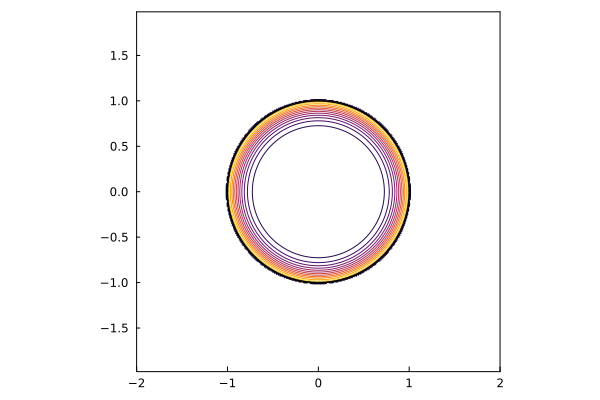

In [17]:
plot(temperature(integrator),sys)

The solution history is in the field `integrator.sol`. The macro we
called earlier enables temperature to work for this, as well, and
we can obtain the temperature at *any* time in the interval of our solution.
For example, to get the solution at time 0.51:

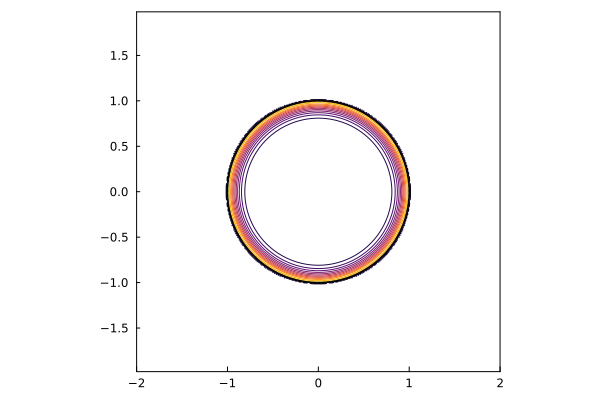

In [18]:
sol = integrator.sol
plot(temperature(sol,sys,0.0051),sys)

We can also get it for an array of times, e.g.,

In [19]:
temperature(sol,sys,0.0051:0.0001:0.0061);

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*